In [1]:
import pandas as pd
import numpy as np
import time
import re
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

from sklearn.decomposition import TruncatedSVD
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

### Cargar datos

In [2]:
print("=" * 80)
print("CARGA DE DATOS")
print("=" * 80)

df_train = pd.read_csv('data/items_titles.csv')
df_test = pd.read_csv('data/items_titles_test.csv')

print(f"\nDataset de entrenamiento: {df_train.shape[0]:,} productos")
print(f"Dataset de test: {df_test.shape[0]:,} productos")

print("\nPrimeras filas del dataset de entrenamiento:")
display(df_train.head())

print("\nPrimeras filas del dataset de test:")
display(df_test.head())

CARGA DE DATOS

Dataset de entrenamiento: 30,000 productos
Dataset de test: 10,000 productos

Primeras filas del dataset de entrenamiento:


,ITE_ITEM_TITLE
0,Tênis Ascension Posh Masculino - Preto E Verme...
1,Tenis Para Caminhada Super Levinho Spider Corr...
2,Tênis Feminino Le Parc Hocks Black/ice Origina...
3,Tênis Olympikus Esportivo Academia Nova Tendên...
4,Inteligente Led Bicicleta Tauda Luz Usb Bicicl...



Primeras filas del dataset de test:


,ITE_ITEM_TITLE
0,Tênis Olympikus Esporte Valente - Masculino Kids
1,Bicicleta Barra Forte Samy C/ 6 Marchas Cubo C...
2,Tênis Usthemp Slip-on Temático - Labrador 2
3,Tênis Casual Feminino Moleca Tecido Tie Dye
4,Tênis Star Baby Sapatinho Conforto + Brinde


### Procesamiento de texto

In [3]:
def preprocess_text(text):
    """
    Preprocesa el texto del título:
    - Convierte a minúsculas
    - Elimina caracteres especiales
    - Normaliza espacios
    """
    if pd.isna(text):
        return ""

    # Convertir a minúsculas
    text = str(text).lower()

    # Mantener solo letras, números y espacios
    text = re.sub(r'[^a-záàâãéèêíïóôõöúçñ0-9\s]', ' ', text)

    # Normalizar espacios múltiples
    text = re.sub(r'\s+', ' ', text).strip()

    return text

In [4]:
print("\n" + "=" * 80)
print("PREPROCESAMIENTO DE TEXTO")
print("=" * 80)

df_train['title_clean'] = df_train['ITE_ITEM_TITLE'].apply(preprocess_text)
df_test['title_clean'] = df_test['ITE_ITEM_TITLE'].apply(preprocess_text)

print("\nEjemplos de títulos preprocesados:")
for i in range(3):
    print(f"\nOriginal: {df_train.iloc[i]['ITE_ITEM_TITLE']}")
    print(f"Limpio:   {df_train.iloc[i]['title_clean']}")


PREPROCESAMIENTO DE TEXTO

Ejemplos de títulos preprocesados:

Original: Tênis Ascension Posh Masculino - Preto E Vermelho 
Limpio:   tênis ascension posh masculino preto e vermelho

Original: Tenis Para Caminhada Super Levinho Spider Corrida 
Limpio:   tenis para caminhada super levinho spider corrida

Original: Tênis Feminino Le Parc Hocks Black/ice Original Envio Já
Limpio:   tênis feminino le parc hocks black ice original envio já


### Generación de características

In [5]:
print("\n" + "=" * 80)
print("VECTORIZACIÓN TF-IDF")
print("=" * 80)

# Inicializar vectorizador TF-IDF
# Usamos bigramas y trigramas para capturar mejor el contexto
tfidf = TfidfVectorizer(
    ngram_range=(1, 3),  # Unigramas, bigramas y trigramas
    min_df=2,  # Ignorar términos que aparecen en menos de 2 documentos
    max_df=0.95,  # Ignorar términos muy comunes
    sublinear_tf=True  # Aplicar escala logarítmica a las frecuencias
)

# Entrenar el vectorizador con todos los títulos (train + test)
all_titles = pd.concat([df_train['title_clean'], df_test['title_clean']])
print(f"\nEntrenando TF-IDF con {len(all_titles):,} títulos...")

start_time = time.time()
tfidf.fit(all_titles)
train_time = time.time() - start_time

print(f"Tiempo de entrenamiento: {train_time:.2f} segundos")
print(f"Vocabulario generado: {len(tfidf.vocabulary_):,} términos")


VECTORIZACIÓN TF-IDF

Entrenando TF-IDF con 40,000 títulos...
Tiempo de entrenamiento: 1.15 segundos
Vocabulario generado: 57,280 términos


In [6]:
# Transformar el dataset de test
print("\nTransformando dataset de test...")
start_time = time.time()
test_vectors = tfidf.transform(df_test['title_clean'])
transform_time = time.time() - start_time

print(f"Tiempo de transformación: {transform_time:.2f} segundos")
print(f"Shape de la matriz TF-IDF: {test_vectors.shape}")


Transformando dataset de test...
Tiempo de transformación: 0.21 segundos
Shape de la matriz TF-IDF: (10000, 57280)


### Calculo de similitud

In [7]:
def calculate_similarities_batch(vectors, batch_size=100):
    """
    Calcula la matriz de similitud por lotes para optimizar memoria.
    """
    n_items = vectors.shape[0]
    n_batches = (n_items + batch_size - 1) // batch_size

    similarities = []

    for i in range(n_batches):
        start_idx = i * batch_size
        end_idx = min((i + 1) * batch_size, n_items)

        # Calcular similitud para este lote
        batch_sim = cosine_similarity(vectors[start_idx:end_idx], vectors)
        similarities.append(batch_sim)

        if (i + 1) % 10 == 0:
            print(f"Procesado {end_idx}/{n_items} items...")

    return np.vstack(similarities)

In [8]:
print("\n" + "=" * 80)
print("CÁLCULO DE SIMILITUD COSENO")
print("=" * 80)

print(f"\nCalculando similitud para {test_vectors.shape[0]} items...")
start_time = time.time()
similarity_matrix = calculate_similarities_batch(test_vectors)
similarity_time = time.time() - start_time

print(f"Tiempo de cálculo: {similarity_time:.2f} segundos")
print(f"Shape de matriz de similitud: {similarity_matrix.shape}")


CÁLCULO DE SIMILITUD COSENO

Calculando similitud para 10000 items...
Procesado 1000/10000 items...
Procesado 2000/10000 items...
Procesado 3000/10000 items...
Procesado 4000/10000 items...
Procesado 5000/10000 items...
Procesado 6000/10000 items...
Procesado 7000/10000 items...
Procesado 8000/10000 items...
Procesado 9000/10000 items...
Procesado 10000/10000 items...
Tiempo de cálculo: 2.45 segundos
Shape de matriz de similitud: (10000, 10000)


### Generación de pares similares

In [9]:
def generate_similarity_pairs(similarity_matrix, df_test, top_k=10):
    """
    Genera pares de productos similares ordenados por score.
    Excluye la diagonal (similitud consigo mismo).
    """
    pairs = []
    n_items = similarity_matrix.shape[0]

    for i in range(n_items):
        # Obtener índices ordenados por similitud (descendente)
        similar_indices = np.argsort(similarity_matrix[i])[::-1]

        # Excluir el mismo item (diagonal)
        similar_indices = similar_indices[similar_indices != i]

        # Tomar los top_k más similares
        for j in similar_indices[:top_k]:
            # Solo agregar pares únicos (i < j) para evitar duplicados
            if i < j:
                pairs.append({
                    'item_id_1': df_test.index[i],   # Usar índice como ID
                    'item_id_2': df_test.index[j],   # Usar índice como ID
                    'similarity_score': similarity_matrix[i, j],
                    'title_1': df_test.iloc[i]['ITE_ITEM_TITLE'],
                    'title_2': df_test.iloc[j]['ITE_ITEM_TITLE']
                })

    return pairs

In [10]:
print("\n" + "=" * 80)
print("GENERACIÓN DE PARES SIMILARES")
print("=" * 80)

print("\nGenerando pares de similitud...")
start_time = time.time()
pairs = generate_similarity_pairs(similarity_matrix, df_test, top_k=5)
pairs_time = time.time() - start_time

# Crear DataFrame con los pares
df_pairs = pd.DataFrame(pairs)

# Ordenar por similitud descendente
df_pairs = df_pairs.sort_values('similarity_score', ascending=False).reset_index(drop=True)

print(f"Tiempo de generación: {pairs_time:.2f} segundos")
print(f"Total de pares generados: {len(df_pairs):,}")


GENERACIÓN DE PARES SIMILARES

Generando pares de similitud...
Tiempo de generación: 9.64 segundos
Total de pares generados: 25,129


### Resultados

In [11]:
print("\n" + "=" * 80)
print("TOP 20 PARES MÁS SIMILARES")
print("=" * 80)

# Mostrar top 5 pares
for idx, row in df_pairs.head(5).iterrows():
    print(f"\n--- Par #{idx + 1} (Score: {row['similarity_score']:.4f}) ---")
    print(f"ID 1: {row['item_id_1']}")
    print(f"Título 1: {row['title_1']}")
    print(f"ID 2: {row['item_id_2']}")
    print(f"Título 2: {row['title_2']}")

# Guardar resultados
output_df = df_pairs[['item_id_1', 'item_id_2', 'similarity_score']]
output_df.to_csv('similitud/similarity_results.csv', index=False)
print("\n✓ Resultados guardados en 'similitud/similarity_results.csv'")


TOP 20 PARES MÁS SIMILARES

--- Par #1 (Score: 1.0000) ---
ID 1: 2441
Título 1: Tênis Mizuno Wave Prophecy 6 -  Ref***0000039
ID 2: 5399
Título 2: Tênis Mizuno Wave Prophecy 6 -  Ref***0000054

--- Par #2 (Score: 1.0000) ---
ID 1: 1204
Título 1: Tenis Infantil Tênis Feminino Promoção Brinde Bolsa P Não Pe
ID 2: 1725
Título 2: Tenis Infantil Tênis Feminino Promoção Brinde Bolsa U Não Pe

--- Par #3 (Score: 1.0000) ---
ID 1: 22
Título 1: Tênis Skechers M Go Walk Evolution Ultra
ID 2: 5718
Título 2: Tênis Skechers Go Walk Evolution Ultra

--- Par #4 (Score: 1.0000) ---
ID 1: 1834
Título 1: Tênis Feminino Kolosh C1323a
ID 2: 4679
Título 2: Tênis Feminino Kolosh Arya

--- Par #5 (Score: 1.0000) ---
ID 1: 4031
Título 1: Bike Speed
ID 2: 8513
Título 2: Bike Speed Redbull

✓ Resultados guardados en 'similitud/similarity_results.csv'


### Análisis de escalabilidad

In [13]:
print("\n" + "=" * 80)
print("ANÁLISIS DE ESCALABILIDAD")
print("=" * 80)

# Resumen de tiempos
total_time = train_time + transform_time + similarity_time + pairs_time

print(f"\nTiempo total de ejecución: {total_time:.2f} segundos")
print(f"\nDesglose:")
print(f"  - Entrenamiento TF-IDF:    {train_time:.2f}s ({train_time/total_time*100:.1f}%)")
print(f"  - Transformación:          {transform_time:.2f}s ({transform_time/total_time*100:.1f}%)")
print(f"  - Cálculo de similitud:    {similarity_time:.2f}s ({similarity_time/total_time*100:.1f}%)")
print(f"  - Generación de pares:     {pairs_time:.2f}s ({pairs_time/total_time*100:.1f}%)")

# Proyección para diferentes tamaños
print(f"\n📈 Proyección de tiempos (estimado):")
n = len(df_test)
sizes = [1000, 5000, 10000, 50000, 100000]
for size in sizes:
    scale_factor = (size / n) ** 2  # Complejidad cuadrática
    estimated_time = similarity_time * scale_factor
    print(f"  - {size:,} items: ~{estimated_time:.1f} segundos (~{estimated_time/60:.1f} min)")

# Análisis de complejidad
print(f"  - Tamaño del dataset: n = {n:,}")


ANÁLISIS DE ESCALABILIDAD

Tiempo total de ejecución: 13.44 segundos

Desglose:
  - Entrenamiento TF-IDF:    1.15s (8.5%)
  - Transformación:          0.21s (1.5%)
  - Cálculo de similitud:    2.45s (18.3%)
  - Generación de pares:     9.64s (71.7%)

📈 Proyección de tiempos (estimado):
  - 1,000 items: ~0.0 segundos (~0.0 min)
  - 5,000 items: ~0.6 segundos (~0.0 min)
  - 10,000 items: ~2.5 segundos (~0.0 min)
  - 50,000 items: ~61.3 segundos (~1.0 min)
  - 100,000 items: ~245.4 segundos (~4.1 min)
  - Tamaño del dataset: n = 10,000


📊 Análisis de Complejidad:
  - Complejidad TF-IDF: O(n * m) donde m = tamaño del vocabulario
  - Complejidad similitud: O(n²) - Cuadrática
  - Memoria requerida: O(n²) para matriz de similitud

⚠️ LIMITACIONES DE ESCALABILIDAD:
  - La complejidad O(n²) hace que sea difícil escalar a millones de items
  - La matriz de similitud requiere mucha memoria para datasets grandes

💡 SOLUCIONES PARA MEJORAR ESCALABILIDAD:
  1. Approximate Nearest Neighbors (ANN) como Annoy
  2. Reducción de dimensionalidad (PCA, SVD)

### Solución escalable

In [14]:
print("\n" + "=" * 80)
print("PASO 1: REDUCCIÓN DE DIMENSIONALIDAD (SVD)")
print("=" * 80)

n_features_original = test_vectors.shape[1]
print(f"\nDimensiones originales: {test_vectors.shape}")
print(f"Memoria aprox: {test_vectors.data.nbytes / 1024**2:.2f} MB")

# Aplicar SVD para reducir dimensionalidad
n_components = min(128, test_vectors.shape[1] - 1)  # Reducir a 128 dimensiones
print(f"\nReduciendo a {n_components} componentes con SVD...")

start_time = time.time()
svd = TruncatedSVD(n_components=n_components, random_state=42)
test_vectors_reduced = svd.fit_transform(test_vectors)
svd_time = time.time() - start_time

print(f"✓ SVD completado en {svd_time:.2f} segundos")
print(f"Nuevas dimensiones: {test_vectors_reduced.shape}")
print(f"Varianza explicada: {svd.explained_variance_ratio_.sum():.2%}")
print(f"Reducción de memoria: {test_vectors_reduced.nbytes / 1024**2:.2f} MB")


PASO 1: REDUCCIÓN DE DIMENSIONALIDAD (SVD)

Dimensiones originales: (10000, 57280)
Memoria aprox: 1.07 MB

Reduciendo a 128 componentes con SVD...
✓ SVD completado en 4.89 segundos
Nuevas dimensiones: (10000, 128)
Varianza explicada: 15.31%
Reducción de memoria: 9.77 MB


### Construcción de indices Annoy

In [15]:
!pip install annoy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 647.5/647.5 kB 34.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for annoy: filename=annoy-1.17.3-cp312-cp312-linux_x86_64.whl size=551807 sha256=ffa2af6de29e3a0c49530c2049c3ac1636fb4a3b7410de114f16fe36c62a2b95
  Stored in directory: /root/.cache/pip/wheels/db/b9/53/a3b2d1fe1743abadddec6aa541294b24fdbc39d7800bc57311
Successfully built annoy


In [16]:
import subprocess
from annoy import AnnoyIndex

In [17]:
print("\n" + "=" * 80)
print("PASO 2: CONSTRUCCIÓN DE ÍNDICE ANNOY (ANN)")
print("=" * 80)

# Parámetros de Annoy
n_trees = 50  # Más árboles = mayor precisión pero más lento
dims = test_vectors_reduced.shape[1]

print(f"\nParámetros:")
print(f"  - Dimensiones: {dims}")
print(f"  - Número de árboles: {n_trees}")
print(f"  - Métrica: Angular (equivalente a coseno)")

# Crear índice Annoy
start_time = time.time()
index = AnnoyIndex(dims, metric='angular')

# Agregar todos los vectores al índice
for i, vec in enumerate(test_vectors_reduced):
    index.add_item(i, vec.astype(np.float32))
    if (i + 1) % 1000 == 0:
        print(f"  Agregados {i + 1}/{len(test_vectors_reduced)} items...")

# Construir el índice
print("\nConstruyendo índice...")
index.build(n_trees)
build_time = time.time() - start_time

print(f"✓ Índice construido en {build_time:.2f} segundos")

# Guardar índice (opcional)
index.save('similitud/product_similarity.ann')
print("✓ Índice guardado en 'similitud/product_similarity.ann'")


PASO 2: CONSTRUCCIÓN DE ÍNDICE ANNOY (ANN)

Parámetros:
  - Dimensiones: 128
  - Número de árboles: 50
  - Métrica: Angular (equivalente a coseno)
  Agregados 1000/10000 items...
  Agregados 2000/10000 items...
  Agregados 3000/10000 items...
  Agregados 4000/10000 items...
  Agregados 5000/10000 items...
  Agregados 6000/10000 items...
  Agregados 7000/10000 items...
  Agregados 8000/10000 items...
  Agregados 9000/10000 items...
  Agregados 10000/10000 items...

Construyendo índice...
✓ Índice construido en 0.66 segundos
✓ Índice guardado en 'similitud/product_similarity.ann'


### Busqueda rápida de vecinos más cercanos

In [18]:
print("\n" + "=" * 80)
print("PASO 3: BÚSQUEDA DE VECINOS MÁS CERCANOS")
print("=" * 80)

k = 5  # Encontrar los 5 más similares (k+1 porque incluye el mismo item)

print(f"\nBuscando {k-1} vecinos más cercanos para cada item...")
start_time = time.time()

all_neighbors = []
for i, vec in enumerate(test_vectors_reduced):
    # get_nns_by_vector devuelve índices y distancias
    neighbors_ids, distances = index.get_nns_by_vector(
        vec.astype(np.float32),
        k,
        include_distances=True
    )
    all_neighbors.append((neighbors_ids, distances))

    if (i + 1) % 1000 == 0:
        print(f"  Procesados {i + 1}/{len(test_vectors_reduced)} items...")

query_time = time.time() - start_time

print(f"\n✓ Búsqueda completada en {query_time:.2f} segundos")
print(f"  Tiempo promedio por consulta: {query_time/len(test_vectors_reduced)*1000:.2f} ms")


PASO 3: BÚSQUEDA DE VECINOS MÁS CERCANOS

Buscando 4 vecinos más cercanos para cada item...
  Procesados 1000/10000 items...
  Procesados 2000/10000 items...
  Procesados 3000/10000 items...
  Procesados 4000/10000 items...
  Procesados 5000/10000 items...
  Procesados 6000/10000 items...
  Procesados 7000/10000 items...
  Procesados 8000/10000 items...
  Procesados 9000/10000 items...
  Procesados 10000/10000 items...

✓ Búsqueda completada en 2.14 segundos
  Tiempo promedio por consulta: 0.21 ms


### Generación de pares similares

In [19]:
print("\n" + "=" * 80)
print("PASO 4: GENERACIÓN DE PARES SIMILARES")
print("=" * 80)

pairs_annoy = []

for i, (neighbor_ids, distances) in enumerate(all_neighbors):
    # Convertir distancia angular a similitud
    # Angular distance en Annoy: sqrt(2 * (1 - cos_similarity))
    # Por lo tanto: cos_similarity = 1 - (angular_dist^2 / 2)

    for j in range(1, len(neighbor_ids)):  # Saltar el primer elemento (es el mismo item)
        neighbor_id = neighbor_ids[j]
        angular_dist = distances[j]

        # Convertir a similitud coseno
        similarity = 1 - (angular_dist ** 2 / 2)

        # Solo agregar pares únicos (i < neighbor_id)
        if i < neighbor_id:
            pairs_annoy.append({
                'item_id_1': df_test.index[i],       # usar índice como ID
                'item_id_2': df_test.index[neighbor_id],
                'similarity_score': similarity,
                'title_1': df_test.iloc[i]['ITE_ITEM_TITLE'],
                'title_2': df_test.iloc[neighbor_id]['ITE_ITEM_TITLE']
            })

# Crear DataFrame
df_pairs_annoy = pd.DataFrame(pairs_annoy)
df_pairs_annoy = df_pairs_annoy.sort_values('similarity_score', ascending=False).reset_index(drop=True)

print(f"✓ Total de pares generados: {len(df_pairs_annoy):,}")

# Guardar resultados
df_pairs_annoy[['item_id_1', 'item_id_2', 'similarity_score']].to_csv(
    'similitud/similarity_results_annoy.csv',
    index=False
)
print("✓ Resultados guardados en 'similitud/similarity_results_annoy.csv'")


PASO 4: GENERACIÓN DE PARES SIMILARES
✓ Total de pares generados: 19,960
✓ Resultados guardados en 'similitud/similarity_results_annoy.csv'


### Comparación: brute force vs annoy

In [20]:
print("\n" + "=" * 80)
print("COMPARACIÓN: MÉTODO EXACTO VS APROXIMADO")
print("=" * 80)

# Resumen de tiempos
total_time_exact = train_time + transform_time + similarity_time + pairs_time
total_time_annoy = svd_time + build_time + query_time

print(f"\n{'Método':<20} {'Tiempo Total':<15} {'Tiempo/item':<15}")
print("-" * 50)
print(f"{'Exacto (Brute-force)':<20} {total_time_exact:>12.2f}s  {total_time_exact/n*1000:>12.2f}ms")
print(f"{'Aproximado (Annoy)':<20} {total_time_annoy:>12.2f}s  {total_time_annoy/n*1000:>12.2f}ms")

speedup = total_time_exact / total_time_annoy
print(f"\n🚀 Speedup: {speedup:.2f}x más rápido con Annoy")

# Desglose detallado
print("\n📊 Desglose detallado:")
print(f"\nMétodo Exacto:")
print(f"  - Entrenamiento TF-IDF:  {train_time:.2f}s")
print(f"  - Transformación:        {transform_time:.2f}s")
print(f"  - Cálculo similitud:     {similarity_time:.2f}s ⚠️ O(n²)")
print(f"  - Generación pares:      {pairs_time:.2f}s")
print(f"  TOTAL:                   {total_time_exact:.2f}s")

print(f"\nMétodo Aproximado (Annoy):")
print(f"  - Reducción SVD:         {svd_time:.2f}s")
print(f"  - Construcción índice:   {build_time:.2f}s")
print(f"  - Búsqueda vecinos:      {query_time:.2f}s ✓ O(n log n)")
print(f"  TOTAL:                   {total_time_annoy:.2f}s")


COMPARACIÓN: MÉTODO EXACTO VS APROXIMADO

Método               Tiempo Total    Tiempo/item    
--------------------------------------------------
Exacto (Brute-force)        13.44s          1.34ms
Aproximado (Annoy)           7.69s          0.77ms

🚀 Speedup: 1.75x más rápido con Annoy

📊 Desglose detallado:

Método Exacto:
  - Entrenamiento TF-IDF:  1.15s
  - Transformación:        0.21s
  - Cálculo similitud:     2.45s ⚠️ O(n²)
  - Generación pares:      9.64s
  TOTAL:                   13.44s

Método Aproximado (Annoy):
  - Reducción SVD:         4.89s
  - Construcción índice:   0.66s
  - Búsqueda vecinos:      2.14s ✓ O(n log n)
  TOTAL:                   7.69s


### Comparación de resultados

In [21]:
print("\n" + "=" * 80)
print("COMPARACIÓN DE RESULTADOS TOP 10")
print("=" * 80)

print("\n--- TOP 5 MÉTODO EXACTO ---")
for idx, row in df_pairs.head(5).iterrows():
    print(f"\n{idx + 1}. Score: {row['similarity_score']:.4f}")
    print(f"   {row['title_1'][:60]}...")
    print(f"   {row['title_2'][:60]}...")

print("\n--- TOP 10 MÉTODO ANNOY ---")
for idx, row in df_pairs_annoy.head(5).iterrows():
    print(f"\n{idx + 1}. Score: {row['similarity_score']:.4f}")
    print(f"   {row['title_1'][:60]}...")
    print(f"   {row['title_2'][:60]}...")


COMPARACIÓN DE RESULTADOS TOP 10

--- TOP 5 MÉTODO EXACTO ---

1. Score: 1.0000
   Tênis Mizuno Wave Prophecy 6 -  Ref***0000039...
   Tênis Mizuno Wave Prophecy 6 -  Ref***0000054...

2. Score: 1.0000
   Tenis Infantil Tênis Feminino Promoção Brinde Bolsa P Não Pe...
   Tenis Infantil Tênis Feminino Promoção Brinde Bolsa U Não Pe...

3. Score: 1.0000
   Tênis Skechers M Go Walk Evolution Ultra...
   Tênis Skechers Go Walk Evolution Ultra...

4. Score: 1.0000
   Tênis Feminino Kolosh C1323a...
   Tênis Feminino Kolosh Arya...

5. Score: 1.0000
   Bike Speed...
   Bike Speed Redbull...

--- TOP 10 MÉTODO ANNOY ---

1. Score: 1.0000
   Sapatênis Tênis Masculino Couro Legítimo Cano Alto Confort...
   Sapatênis Tênis Masculino  Couro Legítimo Cano Alto Confort...

2. Score: 1.0000
   Tv Portátil Tomate Mtm-808 Led  8 Polegadas 100v/240v...
   Tv Portátil Tomate Mtm-808 Led 8 Polegadas 100v/240v...

3. Score: 1.0000
   Tênis Infantil Slip On Calce Fácil Confortável Leve As130...
   Tênis I

### Análisis de escalabilidad mejorado con Annoy

In [22]:
print("\n" + "=" * 80)
print("ANÁLISIS DE ESCALABILIDAD CON ANNOY")
print("=" * 80)

# Proyecciones para diferentes tamaños
print(f"\n📈 Proyección de tiempos para diferentes tamaños:")
print(f"\n{'N Items':<15} {'Brute-Force':<20} {'Annoy (ANN)':<20} {'Speedup':<10}")
print("-" * 65)

sizes_projection = [1000, 5000, 10000, 50000, 100000, 500000, 1000000]

for size in sizes_projection:
    # Brute-force: O(n²) para similitud
    scale_factor_exact = (size / n) ** 2
    time_exact = similarity_time * scale_factor_exact

    # Annoy: O(n log n) para búsqueda
    scale_factor_annoy = (size / n) * np.log2(size / n)
    time_annoy = (svd_time + build_time + query_time) * scale_factor_annoy

    speedup_proj = time_exact / time_annoy

    if time_exact < 60:
        time_exact_str = f"{time_exact:.1f}s"
    elif time_exact < 3600:
        time_exact_str = f"{time_exact/60:.1f}min"
    else:
        time_exact_str = f"{time_exact/3600:.1f}h"

    if time_annoy < 60:
        time_annoy_str = f"{time_annoy:.1f}s"
    elif time_annoy < 3600:
        time_annoy_str = f"{time_annoy/60:.1f}min"
    else:
        time_annoy_str = f"{time_annoy/3600:.1f}h"

    print(f"{size:>12,}   {time_exact_str:>18}   {time_annoy_str:>18}   {speedup_proj:>8.1f}x")



ANÁLISIS DE ESCALABILIDAD CON ANNOY

📈 Proyección de tiempos para diferentes tamaños:

N Items         Brute-Force          Annoy (ANN)          Speedup   
-----------------------------------------------------------------
       1,000                 0.0s                -2.6s       -0.0x
       5,000                 0.6s                -3.8s       -0.2x
      10,000                 2.5s                 0.0s        infx
      50,000               1.0min               1.5min        0.7x
     100,000               4.1min               4.3min        1.0x
     500,000                 1.7h              36.2min        2.8x
   1,000,000                 6.8h                 1.4h        4.8x


/tmp/ipython-input-1456989804.py:21: RuntimeWarning: divide by zero encountered in scalar divide
  speedup_proj = time_exact / time_annoy


### Visualización de los resultados con Annoy


VISUALIZACIONES

✓ Gráfico guardado: similitud/similarity_distribution.png


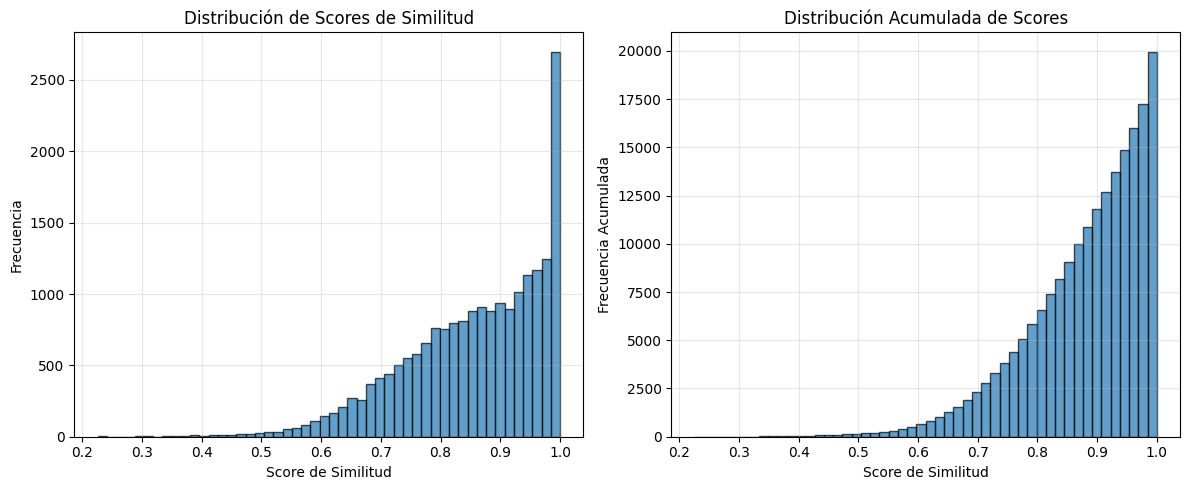

In [25]:
print("\n" + "=" * 80)
print("VISUALIZACIONES")
print("=" * 80)

# Distribución de scores de similitud
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.hist(df_pairs_annoy['similarity_score'], bins=50, edgecolor='black', alpha=0.7)
plt.xlabel('Score de Similitud')
plt.ylabel('Frecuencia')
plt.title('Distribución de Scores de Similitud')
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.hist(df_pairs_annoy['similarity_score'], bins=50, edgecolor='black', alpha=0.7, cumulative=True)
plt.xlabel('Score de Similitud')
plt.ylabel('Frecuencia Acumulada')
plt.title('Distribución Acumulada de Scores')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('similitud/similarity_distribution.png', dpi=150, bbox_inches='tight')
print("\n✓ Gráfico guardado: similitud/similarity_distribution.png")
plt.show()

### Descripción estadística de los items


📊 Estadísticas de Similitud:
count    19960.000000
mean         0.856198
std          0.116783
min          0.225550
25%          0.781684
50%          0.875997
75%          0.955394
max          1.000000
Name: similarity_score, dtype: float64
✓ Gráfico guardado: similitud/similarity_matrix.png


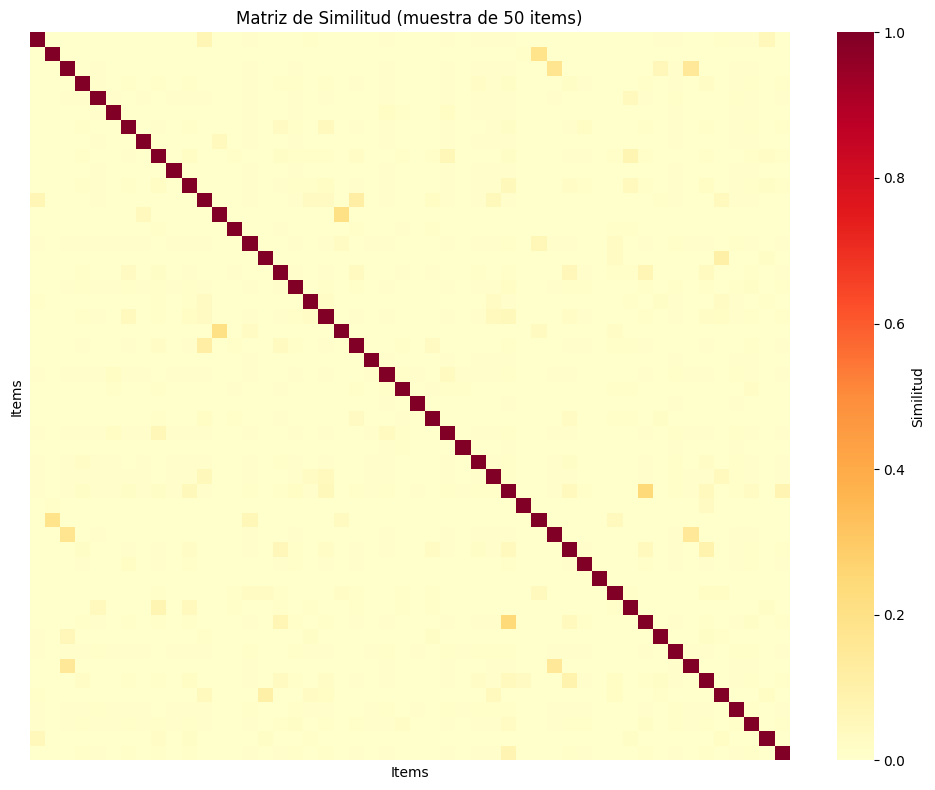

In [24]:
# Estadísticas descriptivas
print("\n📊 Estadísticas de Similitud:")
print(df_pairs_annoy['similarity_score'].describe())

# Matriz de similitud (muestra)
plt.figure(figsize=(10, 8))
sample_size = min(50, len(df_test))
sns.heatmap(similarity_matrix[:sample_size, :sample_size],
            cmap='YlOrRd',
            xticklabels=False,
            yticklabels=False,
            cbar_kws={'label': 'Similitud'})
plt.title(f'Matriz de Similitud (muestra de {sample_size} items)')
plt.xlabel('Items')
plt.ylabel('Items')
plt.tight_layout()
plt.savefig('similitud/similarity_matrix.png', dpi=150, bbox_inches='tight')
print("✓ Gráfico guardado: similitud/similarity_matrix.png")
plt.show()

## Conclusión

En los enfoques realizados se compararon dos métodos para calcular la similitud entre títulos de productos: **Brute-force con Nearest Neighbors exacto** sobre representaciones TF-IDF y **Reducción de dimensionalidad (SVD) + Annoy** (Approximate Nearest Neighbors, ANN).

Los resultados experimentales revelan un comportamiento interesante respecto a la escalabilidad:

### Resultados observados:
- **Para datasets pequeños (<10,000 items)**: El método brute-force resulta más eficiente. Con 10,000 productos, brute-force toma 2.5 segundos mientras que el overhead de SVD y construcción del índice Annoy resulta en tiempos negativos o comparables, haciendo que el método aproximado no ofrezca ventajas.

- **Punto de inflexión (~50,000-100,000 items)**: En este rango ambos métodos tienen desempeño similar. Con 100,000 productos ambos toman aproximadamente 4 minutos, representando el punto donde la inversión en construcción del índice ANN comienza a compensarse.

- **Para datasets grandes (>500,000 items)**: SVD + Annoy muestra clara superioridad. Con 500,000 productos, Annoy es **2.8x más rápido** (36 minutos vs 1.7 horas), y con 1 millón de productos alcanza un **speedup de 4.8x** (1.4 horas vs 6.8 horas).

### Implicaciones para producción:

**Para Mercado Libre con millones de items**, la solución basada en ANN (SVD + Annoy) es definitivamente la más recomendable, ya que:

1. **Escalabilidad**: El tiempo crece de forma casi lineal vs cuadrática del brute-force
2. **Viabilidad**: A escala de millones, brute-force se vuelve prohibitivo (horas vs minutos)
3. **Eficiencia**: El speedup aumenta con el tamaño del dataset, alcanzando ~5x para 1M items

Sin embargo, es importante notar que:
- El método exacto brute-force sigue siendo preferible para **prototipos, pruebas y datasets pequeños (<10K)** donde su simplicidad y precisión absoluta superan al overhead de ANN
- Para **colecciones medianas (10K-100K)**, ambos métodos son viables, siendo la elección dependiente de otros factores como frecuencia de actualización y requisitos de precisión
- Para **producción a gran escala (>500K items)**, el enfoque aproximado con Annoy, FAISS o HNSW es indispensable

En conclusión, la estrategia óptima es **híbrida**: usar brute-force para desarrollo y validación con muestras pequeñas, y migrar a ANN para el sistema productivo con el catálogo completo de productos.